# 🔰PyTorchでニューラルネットワーク基礎 #08 【再帰ネットワーク・LSTM】

### 内容
* Qiitaの記事と連動しています
* LSTMの使い方
* 時系列データである株価を利用してLSTMの構造を学習する


### データについて
* データ：data/nikkei_225.csv
* 2021年から2025年6月中旬くらいのデータ
* 日経225データはyfinanceを利用して取得

### ちょっとした注意点
* CPUでもできるけどGPU（ゲーム用ノートPC搭載のGPUでもOK）あると高速に学習できる
* Google ColaboratoryでももちろんOK

In [1]:
import pandas as pd
import numpy as np

In [2]:
# CSVファイルの読み込み
data = pd.read_csv("./data/nikkei_225.csv")
data.head(5)

,Date,Open,High,Low,Close,Volume
0,2021-01-04,27575.57,27602.11,27042.32,27258.38,51500000
1,2021-01-05,27151.38,27279.78,27073.46,27158.63,55000000
2,2021-01-06,27102.85,27196.40,27002.18,27055.94,72700000
3,2021-01-07,27340.46,27624.73,27340.46,27490.13,98900000
4,2021-01-08,27720.14,28139.03,27667.75,28139.03,84900000


## データセットの作成
* 窓サイズ５の始値データを作成する

## 数値の大きさについて
* 日経平均は3万円前後が多いので、10_000で割り算して値を小さくしてみる
* そのままの金額を利用すると学習が進まないこともあるぞ〜！試してみるのもよいかも



In [3]:
scaling_factor = 10_000
x_open = data["Open"]/scaling_factor

In [4]:
win_size = 5
XO = [x_open[start:start+win_size] for start in range(len(data)-win_size)]
T = x_open[win_size:]

xo = np.array(XO)
t  = np.array(T)
xo = xo.reshape(xo.shape[0], xo.shape[1], 1)
x = xo


# LSTMを利用したネットワークの作成と学習

In [5]:
import torch
import torch.nn as nn

## 学習用データとテストデータに分割
* モデルの予測性能を見るために、テストデータを準備
* テストデータは日経225の最後の100期程度（あとで仮説検定したいのでサイズを大きくしておくことにしよう♪）

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
x = torch.FloatTensor(x).to(device)
t = torch.FloatTensor(t).to(device).view(-1,1)

period = 100
x_train = x[:-period]
x_test = x[-period:]
t_train = t[:-period]
t_test = t[-period:]

x_train.shape, x_test.shape, t_train.shape, t_test.shape

device: cuda


(torch.Size([987, 5, 1]),
 torch.Size([100, 5, 1]),
 torch.Size([987, 1]),
 torch.Size([100, 1]))

### ネットワークの構造
1 dim --> LSTM --> FC1 --> FC2 --> 1 dim

In [8]:
## モデル定義
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn  = nn.LSTM(input_size=1 ,hidden_size=100, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(100, 50)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        o, (h, c)  = self.rnn(x)
        #o = o[:,-1,:]  # 最後のステップの出力を利用する h[-1]
        o = h[-1]
        h = self.fc1(o)
        h = self.act1(h)
        y = self.fc2(h)
        return y

In [11]:
# 学習回数、損失があまり減少しない場合は学習率なども変更してみる
LOOP = 8_000 # GPUじゃないと時間かかる

In [12]:
model = DNN()
model.to(device)

DNN(
  (rnn): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [13]:
# 損失関数と最適化関数の定義
criterion = nn.MSELoss() # 平均二乗誤差
optimizer = torch.optim.AdamW(model.parameters())

In [14]:
# 学習ループ
model.train()
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x_train)
    loss = criterion(y,t_train)   # MSELoss
    if (epoch+1)%500 == 0:
        print(epoch,"\tloss:", loss.item())
    loss.backward()           # 逆伝播微分
    optimizer.step()          # パラメータ更新

499 	loss: 0.004084402229636908
999 	loss: 0.0036492713261395693
1499 	loss: 0.003112269565463066
1999 	loss: 0.0024371815379709005
2499 	loss: 0.002140403725206852
2999 	loss: 0.0019182630348950624
3499 	loss: 0.0017653704853728414
3999 	loss: 0.0016233837231993675
4499 	loss: 0.001485850545577705
4999 	loss: 0.0014066111762076616
5499 	loss: 0.001336920540779829
5999 	loss: 0.0014672455145046115
6499 	loss: 0.0013189591700211167
6999 	loss: 0.001305913901887834
7499 	loss: 0.001302958931773901
7999 	loss: 0.0013022070052102208


# テスト用データを使って検証
* xをtrainとtestで分割した。
~~~
period = 100 # 後半の100期をテスト用に使う
x_train = x[:-period]
x_test = x[-period:]
~~~
* x_testとt_testを利用して、検証を行う。これは実際に学習されていないデータなので面白そう！
* ちゃんと予測できているかグラフで確認
* matplotlibで描画する時、torch.Tensor()をnumpyに戻すのを忘れずに。

In [17]:
import matplotlib.pyplot as plt
import japanize_matplotlib

In [18]:
model.eval()
y_test = model(x_test)

prediction = y_test.detach().cpu().numpy()
real = t_test.detach().cpu().numpy()
y_train = t_train.detach().cpu().numpy()

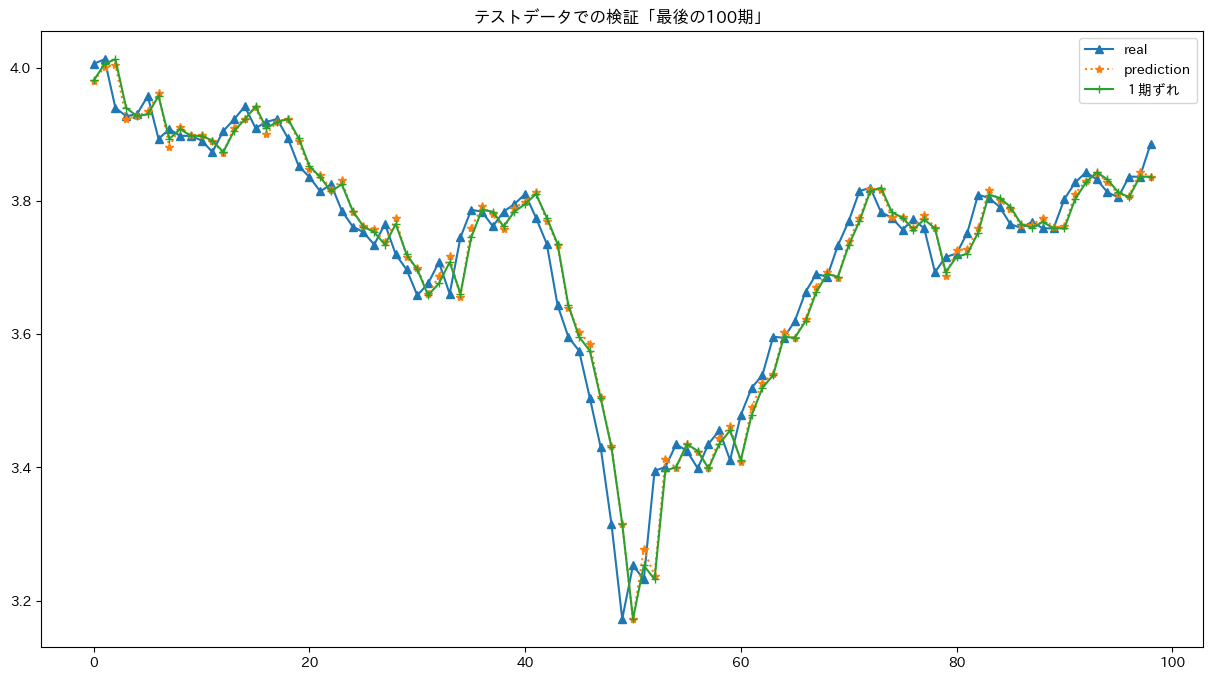

In [19]:
e = period

plt.figure(figsize=(15,8))
plt.plot(real[1:e], label="real", marker="^")
plt.plot(prediction[1:e], label="prediction", linestyle="dotted", marker="*")
plt.plot(real[:e-1], label="１期ずれ", marker="+")
plt.legend()
name = f"テストデータでの検証「最後の{period}期」"
plt.title(name)
plt.show()

## 考察
* 1期ズレている？綺麗に実測値から1期分ずれていることがわかる。
* ナイーブ予測、1期ラグモデルと呼ばれるらしい。